<H1>10,000 DOT invested in the Omnipool for 4 months</H1>

In [1]:
import sys
import os
import glob
import random
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2022', days = 120)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.40},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0.0025,
            lrna_fee=0.0005
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in assets},
            trade_strategy=price_sensitive_trading(
                pool_id='omnipool',
                trade_frequency=1,
                max_volume_usd=100,
                price_sensitivity=25
            )
        ),
        # 'Arbitrageur': Agent(
        #     holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000},
        #     trade_strategy=omnipool_arbitrage(
        #         pool_id='omnipool'
        #     )
        # ),
        'LP': Agent(
            holdings={'USD': 10000},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)
time_steps = len(price_list)-1
# print(f'Running with {time_steps} time steps')
# events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

<h3>Effect of price change on LP returns.</h3> We'll simulate the returns for an LP over the course of four months under a variety of market conditions. We'll see that large price changes - even positive ones - are not best for LPs.

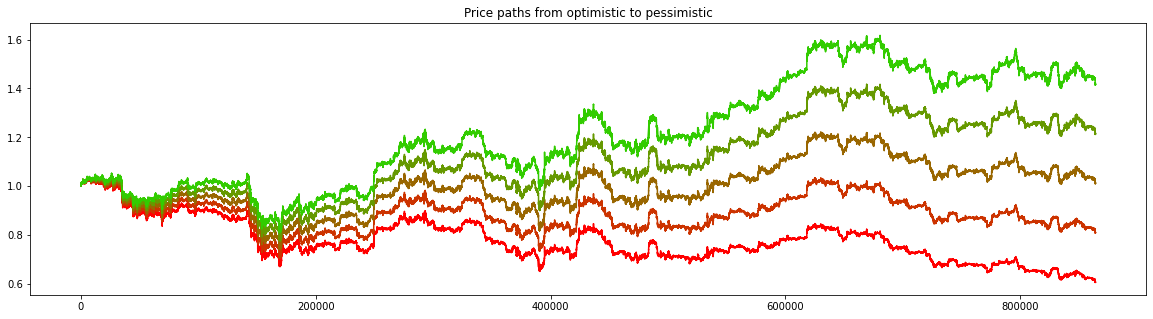

In [2]:
price_path = []
modifier_list = [-0.25, 0, 0.25, 0.5, 0.75]
colors = pu.color_gradient(length=5, color1=(255, 0, 0), color2 = (0, 255, 0))
initial_price_sum = sum([price_list[0][tkn] for tkn in price_list[0]])

plt.figure(figsize=(20, 5))
plt.title("Price paths from optimistic to pessimistic")

for i, price_shift in enumerate(modifier_list):
    price_shift_per_block = price_shift / time_steps
    price_path.append([
        {tkn: price * (1 + i * price_shift_per_block) for tkn, price in assets.items()}
        for i, assets in enumerate(price_list)
    ])
    plt.plot(range(len(price_path[i])), [(price['DOT'] + price['ETH'] + price['BTC']) / initial_price_sum for price in price_path[i]], color=colors[i])

In [3]:
returns = []
dot_price = []
price_events = []
for i, scenario in enumerate(price_path):
    initial_state._evolve_function = historical_prices(scenario)
    random.seed(42)
    events = run.run(initial_state, time_steps)
    price_events.append(events[::100])
    returns.append([cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in price_events[i]])
    dot_price.append(pu.get_datastream(price_events[i], asset='DOT'))
    
print('Trade volume per day as a fraction of TVL:', 
    sum([sum([event.pools['omnipool'].volume_in[tkn] * event.external_market[tkn] for tkn in assets]) for event in events])
    / time_steps / 10000000 * 7200
)

Starting simulation...
Execution time: 47.46 seconds.
Trade volume per day as a fraction of TVL: 0.03520909679361282
Starting simulation...
Execution time: 63.808 seconds.
Trade volume per day as a fraction of TVL: 0.035391445394016986
Starting simulation...
Execution time: 49.814 seconds.
Trade volume per day as a fraction of TVL: 0.03553797056470791
Starting simulation...
Execution time: 49.896 seconds.
Trade volume per day as a fraction of TVL: 0.035658338695471685
Starting simulation...
Execution time: 52.472 seconds.
Trade volume per day as a fraction of TVL: 0.035762166827681456


<h3>Results from the preceeding simulations.</h3> Note that due to impermanent loss, the middle price paths where there is little change from beginning to end fare best.

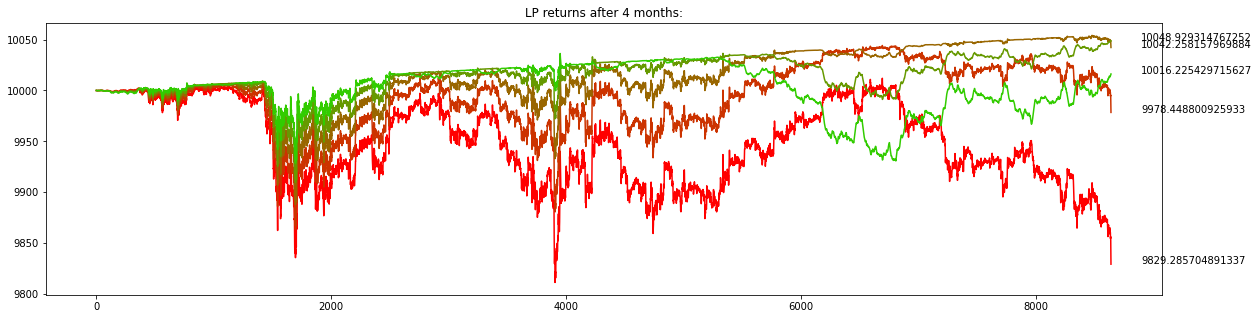

In [4]:
plt.figure(figsize=(20, 5))
plt.title('LP returns after 4 months:')
for i, scenario in enumerate(returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(str(scenario[-1]), xy=(len(scenario), scenario[-1]), xytext=(30,0), textcoords='offset points')

In [6]:
volume_events = []
for i in range(5):
    initial_state._evolve_function = historical_prices(price_path[2])
    initial_state.agents['Trader'].trade_strategy=price_sensitive_trading(
        pool_id='omnipool',
        max_volume_usd=70 * i + 10,
        price_sensitivity=25
    )
    events = run.run(initial_state, time_steps)
    print('Trade volume per day as a fraction of TVL:', 
        sum([sum([event.pools['omnipool'].volume_in[tkn] * event.external_market[tkn] for tkn in assets]) for event in events])
        / time_steps / 10000000 * 7200
    )
    volume_events.append(events[::100])

Starting simulation...
Execution time: 100.709 seconds.
Trade volume per day as a fraction of TVL: 0.003674701755068461
Starting simulation...
Execution time: 519.481 seconds.
Trade volume per day as a fraction of TVL: 0.02875390015907639
Starting simulation...
Execution time: 19209.549 seconds.
Trade volume per day as a fraction of TVL: 0.05210096550663501
Starting simulation...
Execution time: 1169.258 seconds.
Trade volume per day as a fraction of TVL: 0.07399589588320164
Starting simulation...
Execution time: 1891.688 seconds.
Trade volume per day as a fraction of TVL: 0.0947805927754295


<H3>Effects of trade volume.</H3> We'll assume the middle price path for this example (minimum impermanent loss). Trade volume goes from 0.3% to 9.5% of TVL per day. So far we have observed ~5% on average.

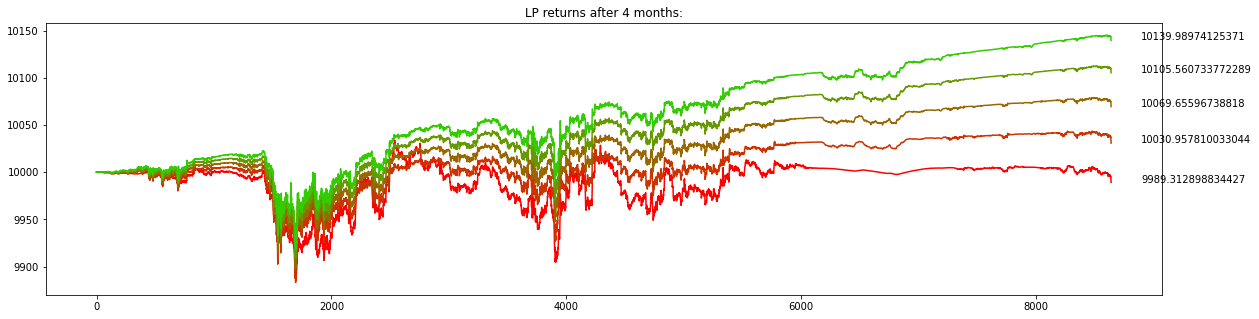

In [8]:
plt.figure(figsize=(20, 5))
plt.title('LP returns after 4 months:')
returns = [[cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events] for events in volume_events]
for i, scenario in enumerate(returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(str(scenario[-1]), xy=(len(scenario), scenario[-1]), xytext=(30,0), textcoords='offset points')

In [9]:
# initial_state._evolve_function = historical_prices(price_path[2])
initial_state.agents['Trader'].trade_strategy=None
events = run.run(initial_state, time_steps)


Starting simulation...
Execution time: 1866.878 seconds.
